**Learning `tcrdist3`**

Reference: 

* Flexible Distance-Based TCR Analysis in Python with tcrdist3, Koshlan Mayer-Blackwell, Andrew Fiore-Gartland, and Paul G. Thomas (Huang Huang and Mark M. Davis (eds.), T-Cell Repertoire Characterization, Methods in Molecular Biology, vol. 2574, https://doi.org/10.1007/978-1-0716-2712-9_16)
* https://tcrdist3.readthedocs.io/en/latest/

In [87]:
import os
import re
import multiprocessing as mp
import IPython
import numpy as np
import pandas as pd
import scipy.sparse
import networkx as nx
from scipy.stats import poisson
from scipy.stats import fisher_exact
import community.community_louvain as community_louvain
from IPython.display import display, HTML, IFrame
import matplotlib.pyplot as plt

In [85]:
from tcrdist import plotting
from tcrdist.repertoire import TCRrep
from tcrdist.html_colors import get_html_colors
from tcrdist.public import _neighbors_fixed_radius
from tcrdist.pgen import OlgaModel
from tcrdist.join import join_by_dist
from tcrdist.swap_gene_name import adaptive_to_imgt


In [3]:
import warnings
warnings.simplefilter('ignore', UserWarning)

**Downlaod preformatted background sequence files**

Only needs to be done once

```python
from tcrsampler.setup_db import install_all_next_gen
install_all_next_gen(dry_run = False)
```

# Analysis of annotated data

How tcrdist3 can be used to interrogate a relatively small number of antigen-specific TCRs that were already annotated using DNA-barcoded pMHC Dextramers

In [4]:
path = 'data'

In [5]:
f = 'clonotypes_minervina.tsv' 

url = 'https://raw.githubusercontent.com/kmayerb/tcrdist3_book_chapter/main/data/clonotypes_minervina.tsv'
if not os.path.isfile(f):
    os.system(r'wget {url}')

Subset to top 6 epitopes.

In [6]:
df = pd.read_csv(f,sep ="\t")

list_of_epitopes = ['A01_TTD', 'A02_YLQ', 'A01_LTD',
                    'B15_NQK', 'A01_FTS', 'A24_NYN']
df = df[ df['epitope'].isin(list_of_epitopes)].reset_index(drop = True)

Rename columns

In [7]:
columns = {
    'cdr3b':'cdr3_b_aa',
    'vb'   :'v_b_gene',
    'jb'   :'j_b_gene',
    'cdr3a':'cdr3_a_aa',
    'va'   :'v_a_gene',
    'ja'   :'j_a_gene',
    'donor':'subject'
}

In [8]:
df = df.rename(columns=columns)

Preview the first 2 lines of DataFrame.

In [9]:
df.head(2)

,cdr3_b_aa,cdr3b_nt,v_b_gene,j_b_gene,cdr3_a_aa,cdr3a_nt,v_a_gene,j_a_gene,clonotype_id,Degree,cl_120,cl_120_members,subject,epitope,specificity,category
0,CASSLAGYEQYF,TGCGCCAGCAGCTTGGCGGGGTACGAGCAGTACTTC,TRBV5-1,TRBJ2-7,CAVDIRAGNMLTF,TGTGCCGTGGACATAAGAGCAGGCAACATGCTCACCTTT,TRAV39,TRAJ39,1,0,1,1,N2,A01_LTD,spike,vax
1,CASSLGFPNQPQHF,TGTGCCAGCAGTTTGGGTTTCCCCAATCAGCCCCAGCATTTT,TRBV27,TRBJ1-5,CGTELRGKLIF,TGCGGCACAGAGCTCCGGGGAAAGCTTATCTTC,TRAV30,TRAJ23,2,0,2,1,R9,A01_LTD,spike,after_2


### Extract from source data

Source: 

* Minervina AA, Pogorelyy MV, Kirk AM et al (2022) SARS-CoV-2 antigen exposure history shapes phenotypes and specificity of memory CD8 + T cells. Nat Immunol 23(5):781–790. https://doi.org/10.1038/s41590-022-01184-4

In [10]:
book = pd.ExcelFile('data/41590_2022_1184_MOESM7_ESM.xlsx')

In [11]:
book.sheet_names

['Data_dictionary', 'clonotypes']

In [12]:
dd = book.parse('Data_dictionary')

In [13]:
clonotypes = book.parse('clonotypes')

In [14]:
clonotypes.head(3)

,cdr3b,cdr3b_nt,vb,jb,cdr3a,cdr3a_nt,va,ja,clonotype_id,Degree,cl_110,cl_110_members,cl_110_fig4,donor,epitope,specificity,category
0,CASSFENQPEAFF,TGCGCCAGCAGCTTTGAGAATCAACCTGAAGCTTTCTTT,TRBV5-1,TRBJ1-1,CAAPGSARQLTF,TGTGCCGCCCCTGGTTCTGCAAGGCAACTGACCTTT,TRAV29/DV5,TRAJ22,1,0,1,1,1.0,R23,A01_DTD,False,inf_vax2
1,CASSLAGYEQYF,TGCGCCAGCAGCTTGGCGGGGTACGAGCAGTACTTC,TRBV5-1,TRBJ2-7,CAVDIRAGNMLTF,TGTGCCGTGGACATAAGAGCAGGCAACATGCTCACCTTT,TRAV39,TRAJ39,2,0,2,1,2.0,N2,A01_LTD,True,vax2
2,CASMSLYQETQYF,TGTGCCAGCATGTCCCTGTACCAAGAGACCCAGTACTTC,TRBV5-6,TRBJ2-5,CAMSVGNNNDMRF,TGTGCAATGAGCGTGGGCAATAACAATGACATGCGCTTT,TRAV12-3,TRAJ43,3,0,3,1,3.0,R7,A01_TTD,False,inf


In [15]:
clonotypes = clonotypes[clonotypes['epitope'].isin(list_of_epitopes)].reset_index(drop = True)

In [16]:
clonotypes = clonotypes.rename(columns=columns)

In [17]:
clonotypes.head(2)

,cdr3_b_aa,cdr3b_nt,v_b_gene,j_b_gene,cdr3_a_aa,cdr3a_nt,v_a_gene,j_a_gene,clonotype_id,Degree,cl_110,cl_110_members,cl_110_fig4,subject,epitope,specificity,category
0,CASSLAGYEQYF,TGCGCCAGCAGCTTGGCGGGGTACGAGCAGTACTTC,TRBV5-1,TRBJ2-7,CAVDIRAGNMLTF,TGTGCCGTGGACATAAGAGCAGGCAACATGCTCACCTTT,TRAV39,TRAJ39,2,0,2,1,2.0,N2,A01_LTD,True,vax2
1,CASMSLYQETQYF,TGTGCCAGCATGTCCCTGTACCAAGAGACCCAGTACTTC,TRBV5-6,TRBJ2-5,CAMSVGNNNDMRF,TGTGCAATGAGCGTGGGCAATAACAATGACATGCGCTTT,TRAV12-3,TRAJ43,3,0,3,1,3.0,R7,A01_TTD,False,inf


In [18]:
clonotypes.columns

Index(['cdr3_b_aa', 'cdr3b_nt', 'v_b_gene', 'j_b_gene', 'cdr3_a_aa',
       'cdr3a_nt', 'v_a_gene', 'j_a_gene', 'clonotype_id', 'Degree', 'cl_110',
       'cl_110_members', 'cl_110_fig4', 'subject', 'epitope', 'specificity',
       'category'],
      dtype='object')

In [19]:
df.columns

Index(['cdr3_b_aa', 'cdr3b_nt', 'v_b_gene', 'j_b_gene', 'cdr3_a_aa',
       'cdr3a_nt', 'v_a_gene', 'j_a_gene', 'clonotype_id', 'Degree', 'cl_120',
       'cl_120_members', 'subject', 'epitope', 'specificity', 'category'],
      dtype='object')

### Subsequent analysis will use provided data in `df`

Add *01 allele level designation

In [20]:
for col in df.columns[df.columns.str.match('^[vj]_')]:
    df[col] = df[col].apply(lambda x: f"{x}*01") 
df['count'] = 1

In [21]:
df.head()

,cdr3_b_aa,cdr3b_nt,v_b_gene,j_b_gene,cdr3_a_aa,cdr3a_nt,v_a_gene,j_a_gene,clonotype_id,Degree,cl_120,cl_120_members,subject,epitope,specificity,category,count
0,CASSLAGYEQYF,TGCGCCAGCAGCTTGGCGGGGTACGAGCAGTACTTC,TRBV5-1*01,TRBJ2-7*01,CAVDIRAGNMLTF,TGTGCCGTGGACATAAGAGCAGGCAACATGCTCACCTTT,TRAV39*01,TRAJ39*01,1,0,1,1,N2,A01_LTD,spike,vax,1
1,CASSLGFPNQPQHF,TGTGCCAGCAGTTTGGGTTTCCCCAATCAGCCCCAGCATTTT,TRBV27*01,TRBJ1-5*01,CGTELRGKLIF,TGCGGCACAGAGCTCCGGGGAAAGCTTATCTTC,TRAV30*01,TRAJ23*01,2,0,2,1,R9,A01_LTD,spike,after_2,1
2,CASSDDGTGIETQYF,TGTGCCAGCAGCGATGATGGGACAGGGATTGAGACCCAGTACTTC,TRBV9*01,TRBJ2-5*01,CAASAFISNTGKLIF,TGTGCAGCAAGCGCATTCATAAGCAACACAGGCAAACTAATCTTT,TRAV29/DV5*01,TRAJ37*01,3,0,3,1,R6,A01_TTD,non-spike,inf,1
3,CASSEGITSNQPQHF,TGTGCCAGCAGCGAAGGGATTACTAGCAATCAGCCCCAGCATTTT,TRBV7-2*01,TRBJ1-5*01,CAVRTSGTYKYIF,TGTGCTGTGAGAACCTCAGGAACCTACAAATACATCTTT,TRAV21*01,TRAJ40*01,5,5,4,7,R6,A01_LTD,spike,inf_vax,1
4,CASSNPGPWGSPLHF,TGTGCCAGCAGTAATCCGGGACCCTGGGGCTCACCCCTCCACTTT,TRBV6-5*01,TRBJ1-6*01,CAVPGNNDMRF,TGTGCCGTCCCGGGTAACAATGACATGCGCTTT,TRAV39*01,TRAJ43*01,10,0,6,1,N4,A01_LTD,spike,vax,1


In [22]:
df.shape

(742, 17)

### Initialize `TCRrep`

In [23]:
targets = [
    'subject',
    'epitope',
    'cdr3_a_aa',
    'v_a_gene',
    'j_a_gene',
    'cdr3_b_aa',
    'v_b_gene',
    'j_b_gene',
    'category',
    'count',
    'cdr3a_nt',
    'cdr3b_nt'
]

In [24]:
%%time

tr = TCRrep(
    cell_df = df[targets],
    organism = 'human',
    chains = ['alpha','beta'],
    deduplicate = True,
    compute_distances = True
)

CPU times: user 732 ms, sys: 41.3 ms, total: 773 ms
Wall time: 812 ms


#### Check default distance weights

In [25]:
np.all(tr.pw_beta == (tr.weights_b['cdr1_b_aa']*tr.pw_cdr1_b_aa +
                      tr.weights_b['cdr2_b_aa']*tr.pw_cdr2_b_aa+
                      tr.weights_b['pmhc_b_aa']*tr.pw_pmhc_b_aa +
                      tr.weights_b['cdr3_b_aa']*tr.pw_cdr3_b_aa))

True

Calculate overall distance

In [26]:
tr.pw_alpha_beta = tr.pw_beta + tr.pw_alpha

In [27]:
tr.pw_alpha_beta.shape

(742, 742)

#### Alternative distances

There are additional options that allow customization of the pairwise distance computation or use of alternative metrics such as the Smith-Waterman alignment score, aligned Hamming distance, or edit distance. The tcrdist3 project’s documentation page (https://tcrdist3.readthedocs.io/) discusses these options in more detail and Appendix B of this chapter illustrates how to compute pairwise CDR3-only edit distance instead of multi-CDR TCRdist

### Visualizing Networks

In [28]:
# <edge_threshold> is used to define maximum distance to for a network edge. 
edge_threshold = 120

# <tr.pw_alpha_beta> is paired chain TCRdist.
tr.pw_alpha_beta = tr.pw_beta + tr.pw_alpha

# <network> initialize a list to populate with edges between TCRs.
network = list()
for i,n in enumerate(_neighbors_fixed_radius(tr.pw_alpha_beta, edge_threshold)):
    for j in n:
        if i != j:
            network.append((
                i,
                j,
                (tr.pw_alpha_beta)[i,j],
                tr.clone_df['v_b_gene'].iloc[i],
                tr.clone_df['v_b_gene'].iloc[j],
                tr.clone_df['cdr3_b_aa'].iloc[i],
                tr.clone_df['cdr3_b_aa'].iloc[j],
                tr.clone_df['subject'].iloc[i],
                tr.clone_df['subject'].iloc[j],
                tr.clone_df['epitope'].iloc[i],
                tr.clone_df['epitope'].iloc[j],
                len(n)-1))

cols = ['node_1', 'node_2', 'dist', 'v_b_gene_1', 'v_b_gene_2',
        'cdr3_b_aa_1','cdr3_b_aa_2', 'subject_1','subject_2',
        'epitope_1','epitope_2', 'K_neighbors']
df_net = pd.DataFrame(network, columns = cols)

# Option to write the edge list to a file for use in Gephi, Cytoscape, R, etc. 
outfile = os.path.join(path,f"{f}_paired_TCRdist_{edge_threshold}_network.csv") 
df_net.to_csv(outfile, sep = ",", index = False)

In [29]:
df_net['public'] = df_net.apply(lambda x : x['subject_1'] != x['subject_2'], axis = 1)
df_net['consistent'] = df_net.apply(lambda x : x['epitope_1'] == x['epitope_2'], axis = 1) 
df_net['weight'] = (edge_threshold - df_net['dist'])/edge_threshold

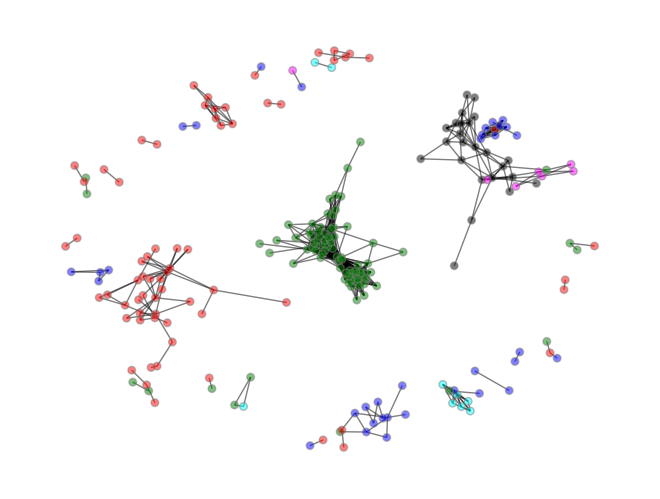

In [30]:
df_net = df_net.query('public == True')
G = nx.from_pandas_edgelist(
    pd.DataFrame(
        {
            'source' : df_net['node_1'], 
            'target' : df_net['node_2'],
            'weight' : df_net['weight']
        }
    )
)

# Assign each node a color based on its epitope annotation.
epitopes = ['A01_TTD', 'A02_YLQ', 'A01_LTD', 'B15_NQK', 'A01_FTS', 'A24_NYN'] 

# Get the same nunber of colors as unique epitopes
colors = get_html_colors(len(epitopes))

# Construct a dictionary to lookup color by epitope.
color_by_epitope = {epitope: color for epitope,color in zip(epitopes,colors)} 

# Assign colors to each node based on its epitope annotation.
node_colors = {node: color_by_epitope.get(epitope) for node, epitope in
               zip(df_net['node_1'],df_net['epitope_1'])}

# Positions for all nodes according to a spring layout.
pos = nx.spring_layout(G, seed=2, k = .15)

# Define aesthetic options
options = {"edgecolors": "tab:gray", "node_size": 30, "alpha": 0.5} 
nx.draw(
    G,
    nodelist = G.nodes,
    pos = pos,
    node_color= [node_colors[node] for node in G.nodes], 
    **options
)

#### Color by community label

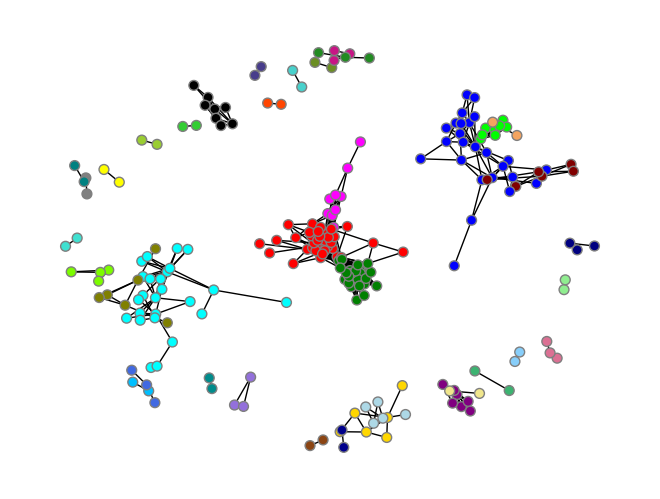

In [31]:
# Find community label
partition= community_louvain.best_partition(G)

# Change partition such that cluster Id is in descending order based on community size
partitions_by_cluster_size = list(pd.Series(partition.values()).value_counts().index) 
partition_reorder = {id:rank for id,rank in zip(partitions_by_cluster_size,
                                                range(len(partitions_by_cluster_size)))} 
partition = {k:partition_reorder.get(v) for k,v in partition.items()}

clusters = [i for i in pd.Series(partition.values()).value_counts().index] 
colors = get_html_colors(len(clusters))
cluster_to_color = {cluster:color for cluster,color, in zip(clusters,colors)} 
options = {"edgecolors": "tab:gray","node_size": 50}
pos = nx.spring_layout(G, seed=2, k = .15)
nx.draw(G,
nodelist = G.nodes,
pos = pos,
node_color=[cluster_to_color.get(partition.get(i)) for i in G.nodes], **options)

#### Visualizaing a subgraph

subset to focus on TCRs annotated as recognizing the HLA-A*02 YLQPRTFLL (A02_YLQ) epitope in the SARS-CoV-2 spike pro- tein.

In [32]:
df.columns

Index(['cdr3_b_aa', 'cdr3b_nt', 'v_b_gene', 'j_b_gene', 'cdr3_a_aa',
       'cdr3a_nt', 'v_a_gene', 'j_a_gene', 'clonotype_id', 'Degree', 'cl_120',
       'cl_120_members', 'subject', 'epitope', 'specificity', 'category',
       'count'],
      dtype='object')

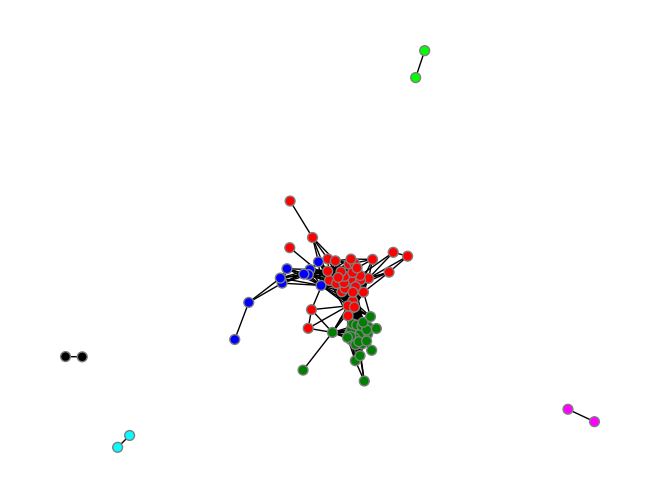

In [33]:
epitopes = ["A02_YLQ"]

df_ = df[ df['epitope'].isin(epitopes)].reset_index(drop = True)

tr = TCRrep(cell_df = df_[['subject',
                           'epitope',
                           'cdr3_a_aa', 'v_a_gene','j_a_gene',
                           'cdr3_b_aa','v_b_gene','j_b_gene',
                           'category', 
                           'count',
                           'cdr3a_nt',
                           'cdr3b_nt']],
            organism = 'human',
            chains = ['alpha','beta'], deduplicate = True, compute_distances = True)

network = list()
for i,n in enumerate(_neighbors_fixed_radius(tr.pw_beta+tr.pw_alpha, edge_threshold)):
    for j in n:
        if i != j:
            network.append(( 
                i, # 'node_1' - row index
                j, # 'node_2' - column index
                (tr.pw_beta + tr.pw_alpha)[i,j] # 'dist'- gets the distance between TCR(i,j)
            ))
cols = ['node_1', 'node_2', 'dist']
df_net = pd.DataFrame(network, columns = cols) 
df_net['weight'] = edge_threshold - df_net['dist']

G = nx.from_pandas_edgelist(
    pd.DataFrame(
        {
            'source' : df_net['node_1'], 
            'target' : df_net['node_2'],
            'weight' : df_net['weight']
        }
    )
)

partition= community_louvain.best_partition(G)

# Change partition such that cluster Id is in descending order based on community size
partitions_by_cluster_size = list(pd.Series(partition.values()).value_counts().index) 
partition_reorder = {id:rank for id,rank in zip(partitions_by_cluster_size,
                                                range(len(partitions_by_cluster_size)))} 
partition = {k:partition_reorder.get(v) for k,v in partition.items()}

clusters = [i for i in pd.Series(partition.values()).value_counts().index] 
colors = get_html_colors(len(clusters))
cluster_to_color = {cluster:color for cluster,color, in zip(clusters,colors)} 
options = {"edgecolors": "tab:gray","node_size": 50}
pos = nx.spring_layout(G, seed=2, k = .15)
nx.draw(G,
nodelist = G.nodes,
pos = pos,
node_color=[cluster_to_color.get(partition.get(i)) for i in G.nodes], **options)

### Sankey diagram for gene segment usage of clones

In [34]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

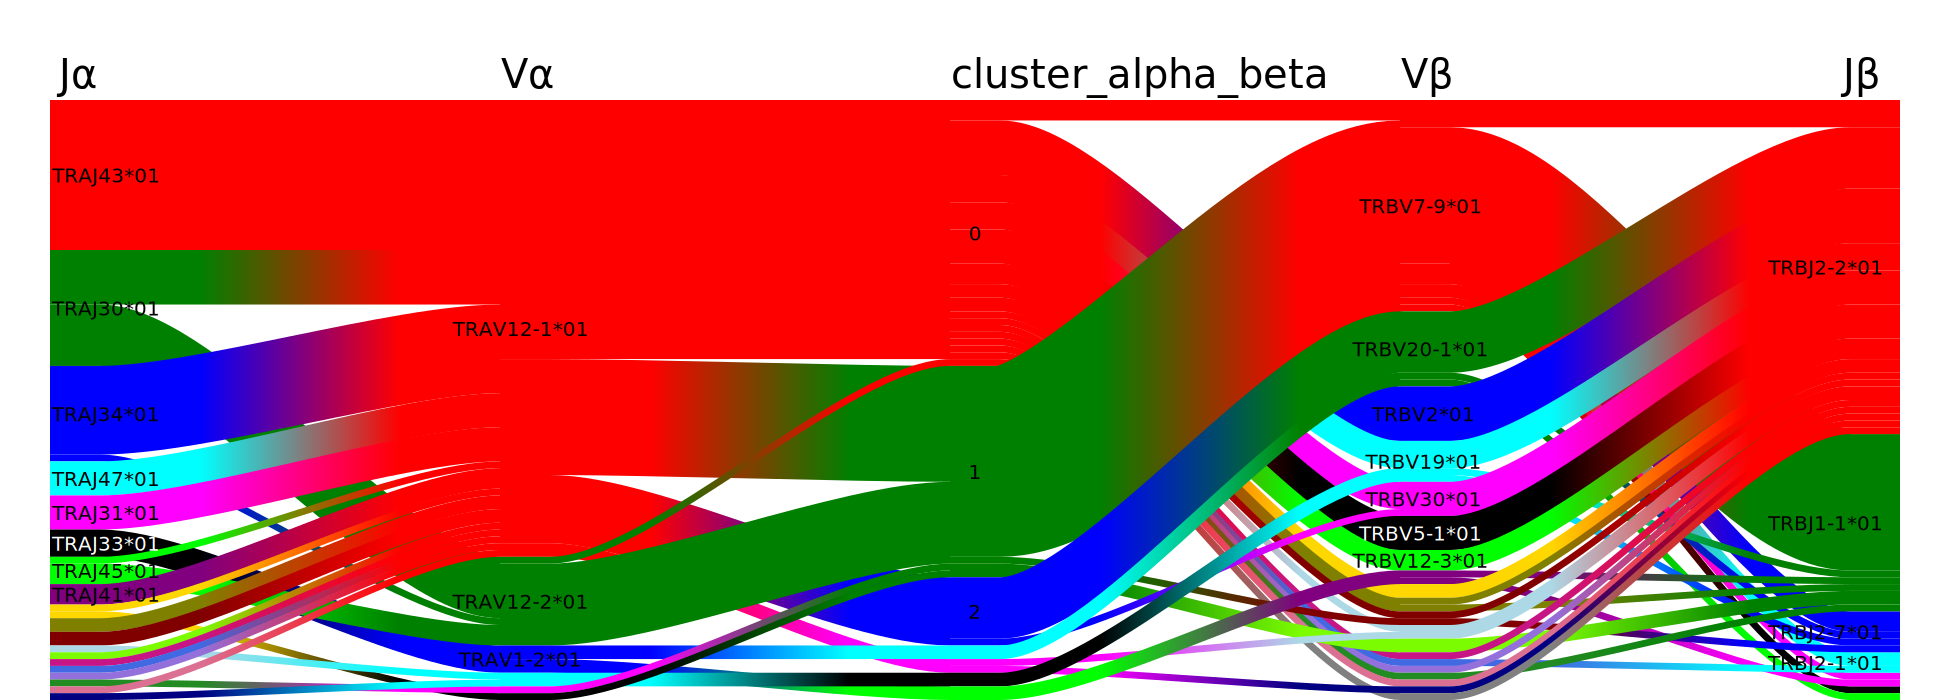

In [35]:
clone_df_ylq = tr.clone_df.copy()
clone_df_ylq['cluster_alpha_beta'] = [
    str(partition.get(i)) if partition.get(i) is not None else None
    for i in clone_df_ylq.index
]

# Note that not all clones were part of the network so subset to those
# that are .notna()
clone_df_ylq_clustered = clone_df_ylq[clone_df_ylq.cluster_alpha_beta.notna()]
svg = plotting.plot_pairings(cell_df = clone_df_ylq_clustered,
                             cols = ['j_a_gene','v_a_gene',
                                     'cluster_alpha_beta',
                                     'v_b_gene' ,'j_b_gene'],
                             count_col='count')
IPython.display.SVG(data=svg)

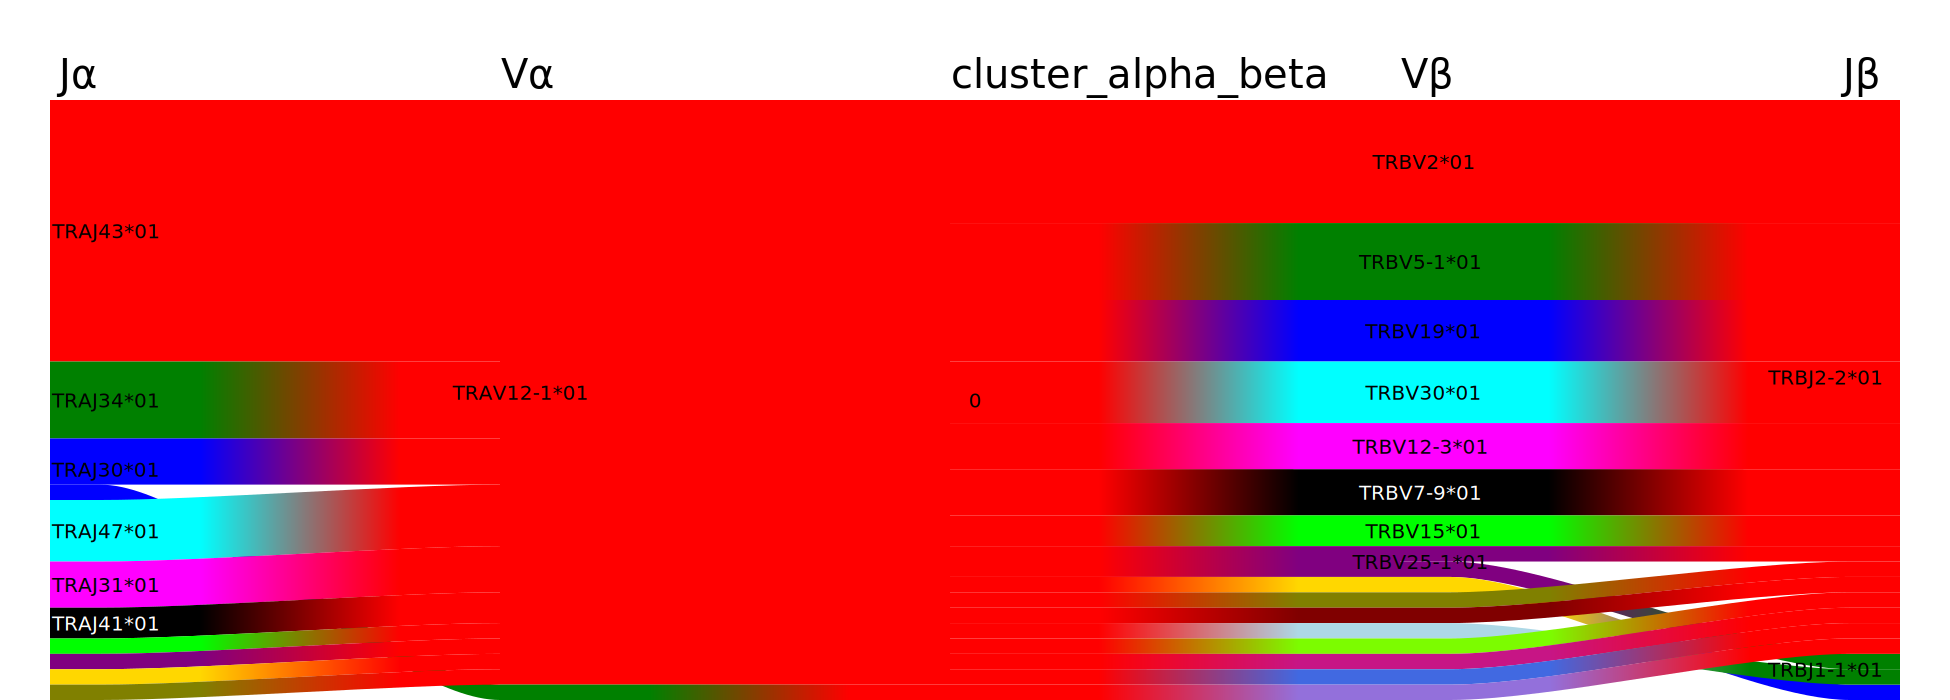

In [36]:
with open("YLQ_clusters.svg", 'w') as oh: 
    oh.write(svg)

cluster_df =  clone_df_ylq.query("cluster_alpha_beta == '0'")
svg = plotting.plot_pairings(cell_df = cluster_df,
                             cols = ['j_a_gene','v_a_gene','cluster_alpha_beta', 'v_b_gene' , 'j_b_gene'],
                             count_col='count')
IPython.display.SVG(data=svg)

#### Gene Usage with Sankey Diagram

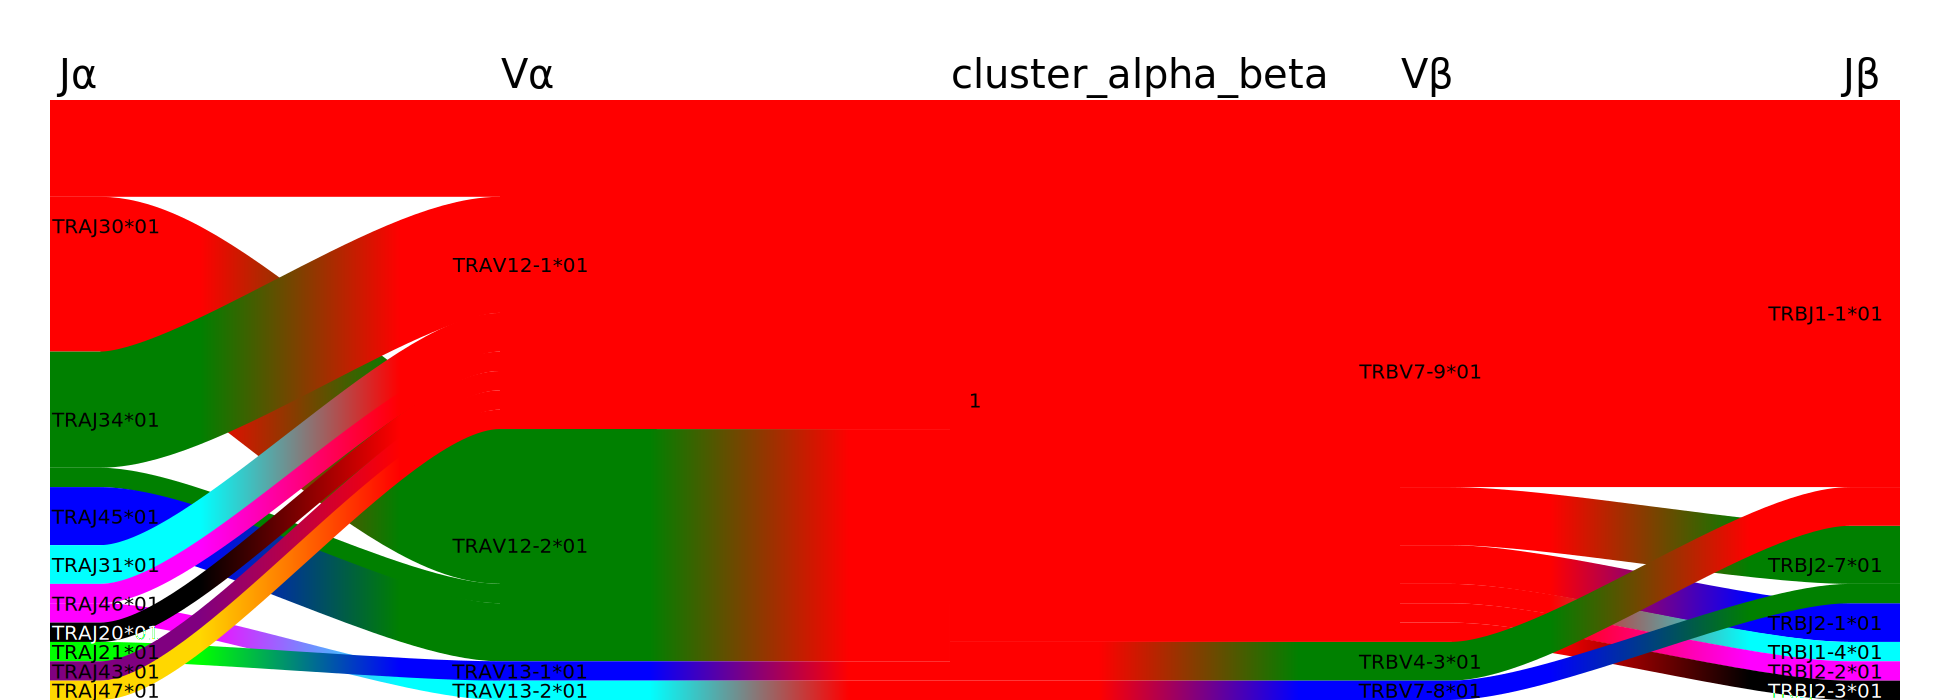

In [37]:
cluster_df =  clone_df_ylq.query("cluster_alpha_beta == '1'")
svg = plotting.plot_pairings(cell_df = cluster_df,
                             cols = ['j_a_gene','v_a_gene','cluster_alpha_beta', 'v_b_gene' , 'j_b_gene'],
                             count_col='count')
IPython.display.SVG(data=svg)

### Background-subtracted CDR3 Logos

To visually identify those portions of the motif that are unexpected beyond residues contributed by germline V and J gene segments, tcrdist3 allows users to generate “background-subtracted” logos. 

In [38]:
from palmotif import compute_pal_motif, svg_logo
from tcrsampler.sampler import TCRsampler
from tcrdist.regex import _matrix_to_regex

# This step can take up to 1 minute, so be patient
ts_beta = TCRsampler(default_background = 'britanova_human_beta_t_cb.tsv.sampler.tsv') 
ts_beta.build_background(max_rows = 50, stratify_by_subject = True)
ts_alpha = TCRsampler(default_background = 'olga_human_alpha_t.sampler.tsv')
ts_alpha.build_background(max_rows = 50, stratify_by_subject = True)

In [39]:
gene_usage_alpha = (cluster_df.groupby(['v_a_gene','j_a_gene']).
                    size().
                    reset_index().
                    to_dict('split ')['data'])
gene_usage_alpha

[['TRAV12-1*01', 'TRAJ20*01', 1],
 ['TRAV12-1*01', 'TRAJ30*01', 5],
 ['TRAV12-1*01', 'TRAJ31*01', 2],
 ['TRAV12-1*01', 'TRAJ34*01', 6],
 ['TRAV12-1*01', 'TRAJ43*01', 1],
 ['TRAV12-1*01', 'TRAJ46*01', 1],
 ['TRAV12-1*01', 'TRAJ47*01', 1],
 ['TRAV12-2*01', 'TRAJ30*01', 8],
 ['TRAV12-2*01', 'TRAJ34*01', 1],
 ['TRAV12-2*01', 'TRAJ45*01', 3],
 ['TRAV13-1*01', 'TRAJ21*01', 1],
 ['TRAV13-2*01', 'TRAJ46*01', 1]]

In [40]:
gene_usage_beta = (cluster_df.groupby(['v_b_gene','j_b_gene']).
                   size().
                   reset_index().
                   to_dict('split' )['data'])
gene_usage_beta

[['TRBV4-3*01', 'TRBJ1-1*01', 2],
 ['TRBV7-8*01', 'TRBJ2-7*01', 1],
 ['TRBV7-9*01', 'TRBJ1-1*01', 20],
 ['TRBV7-9*01', 'TRBJ1-4*01', 1],
 ['TRBV7-9*01', 'TRBJ2-1*01', 2],
 ['TRBV7-9*01', 'TRBJ2-2*01', 1],
 ['TRBV7-9*01', 'TRBJ2-3*01', 1],
 ['TRBV7-9*01', 'TRBJ2-7*01', 3]]

In [41]:
sampled_rep_alpha = ts_alpha.sample(gene_usage_alpha, flatten = True, depth = 100) 
# remove any None values that could have been generated by unknown pairs 
sampled_rep_alpha = [x for x in sampled_rep_alpha if x is not None]

sampled_rep_beta = ts_beta.sample(gene_usage_beta , flatten = True, depth = 100)
# remove any None values that could have been generated by unknown pairs 
sampled_rep_beta = [x for x in sampled_rep_beta if x is not None]

In [42]:
# ALPHA CHAIN
motif, stat = compute_pal_motif(
    seqs = cluster_df['cdr3_a_aa'].to_list(),
    refs = sampled_rep_alpha,
    centroid = cluster_df['cdr3_a_aa'].value_counts().index[0])

background_subtracted_svg_alpha = svg_logo(motif, return_str= True).\
  replace('height="100%"', 'height="20%"').\
  replace('width="100%"', 'width="20%"')

motif_raw, stat_raw = compute_pal_motif(
    seqs = cluster_df['cdr3_a_aa'].to_list(),
    refs = None,
    centroid = cluster_df['cdr3_a_aa'].value_counts().index[0])

raw_svg_alpha = svg_logo(motif_raw, return_str= True).\
  replace('height="100%"', 'height="20%"').\
  replace('width="100%"', 'width="20%"')

regex_alpha = _matrix_to_regex(motif_raw,max_ambiguity=5, ntrim=0, ctrim=0)

# BETA CHAIN
motif, stat = compute_pal_motif(
    seqs = cluster_df['cdr3_b_aa'].to_list(),
    refs = sampled_rep_beta,
    centroid = cluster_df['cdr3_b_aa'].value_counts().index[0])

background_subtracted_svg_beta = svg_logo(motif, return_str= True).\
replace('height="100%"', 'height="20%"').replace('width="100%"', 'width="20%"')

motif_raw, stat_raw = compute_pal_motif(
    seqs = cluster_df['cdr3_b_aa'].to_list(),
    refs = None,
    centroid = cluster_df['cdr3_b_aa'].value_counts().index[0])

raw_svg_beta = svg_logo(motif_raw, return_str= True).\
replace('height="100%"', 'height="20%"').replace('width="100%"', 'width="20%"')

regex_beta = _matrix_to_regex(motif_raw, max_ambiguity=5, ntrim=0, ctrim=0)

In [43]:
regex_alpha

'(C[AGV][EGLV][NK]..[ND][RGK]?[ILMF].F)'

In [44]:
cluster_id = 1

no_wrap_div = '''<div><h3>Cluster {}</h3></div>
<div style="white-space: nowrap">{}{}<br></br>{}{}</div>'''

HTML(no_wrap_div.format(cluster_id, 
                        background_subtracted_svg_alpha,
                        background_subtracted_svg_beta, 
                        raw_svg_alpha,
                        raw_svg_beta))

# Finding Similar TCRs in Unannotated TCRs

In [45]:
from tcrdist.breadth import get_safe_chunk
from tcrdist.join import join_by_dist

In [46]:
url = 'https://github.com/kmayerb/tcrdist3_book_chapter/raw/main/data/GSE158055_covid19_tcr_vdjnt_pclone.tsv.gz'

f = 'GSE158055_covid19_tcr_vdjnt_pclone.tsv.gz' 
if not os.path.isfile(f):
    os.system(f'wget {url}')
# Make a folder 'data' where some outputs will be written
path = 'data'
if not os.path.isdir(path): 
    os.mkdir(path)

Preprocess the data from Ren et al.,(2021) COVID-19 immune features revealed by a large-scal e single-cell transcriptome atlas. Cell 184:1895-1913.e19


In [47]:
columns = {'PatientID' :'subject',
           'TCRA_vgene' :'v_a_gene',
           'TCRA_jgene' : 'j_a_gene',
           'TCRA_cdr3aa':'cdr3_a_aa',
           'TCRB_vgene' :'v_b_gene',
           'TCRB_jgene' :'j_b_gene',
           'TCRB_cdr3aa':'cdr3_b_aa',
           'TCR_pclone.freq':'count'}
ren = pd.read_csv(f, sep = '\t')
ren = ren[columns.keys()].\
rename(columns = columns)
ren['v_b_gene'] = ren['v_b_gene'].apply(lambda x: f"{x}*01") 
ren['v_a_gene'] = ren['v_a_gene'].apply(lambda x: f"{x}*01") 
ren['j_b_gene'] = ren['j_b_gene'].apply(lambda x: f"{x}*01") 
ren['j_a_gene'] = ren['j_a_gene'].apply(lambda x: f"{x}*01") 
ren.head(5)

,subject,v_a_gene,j_a_gene,cdr3_a_aa,v_b_gene,j_b_gene,cdr3_b_aa,count
0,P-M044,TRAV4*01,TRAJ34*01,CLVDLYNTDKLIF,TRBV20-1*01,TRBJ2-7*01,CSATWRRRESPYEQYF,1
1,P-M044,TRAV13-2*01,TRAJ8*01,CAEMENTGFQKLVF,TRBV16*01,TRBJ2-2*01,CASSQLSPGPRNTGELFF,145
2,P-M044,TRAV13-2*01,TRAJ8*01,CAEMENTGFQKLVF,TRBV16*01,TRBJ2-2*01,CASSQLSPGPRNTGELFF,145
3,P-M044,TRAV1-2*01,TRAJ20*01,CAVRDGDYKLSF,TRBV20-1*01,TRBJ2-1*01,CSARPGLASYNEQFF,1
4,P-M044,TRAV13-2*01,TRAJ8*01,CAEMENTGFQKLVF,TRBV16*01,TRBJ2-2*01,CASSQLSPGPRNTGELFF,145


We might initially consider whether there are CDR3 alpha and CDR3 beta amino acid sequences found in the Ren et al. dataset that match any of the “cluster 0” TCRs annotated as A*02 YLQ-specific in the Minervina et al. dataset from Example 3.1.

We find that there are none, as a merge on identical CDR3 amino acid sequences results in an empty DataFrame.

In [48]:
cluster_id = '0'
cluster_df = clone_df_ylq[clone_df_ylq.cluster_alpha_beta == cluster_id].reset_index(drop = True)
cluster_df[['v_a_gene','cdr3_a_aa', 'v_b_gene','cdr3_b_aa']].\
    merge(ren, how = "inner" , on = ['cdr3_b_aa','cdr3_b_aa'])

,v_a_gene_x,cdr3_a_aa_x,v_b_gene_x,cdr3_b_aa,subject,v_a_gene_y,j_a_gene,cdr3_a_aa_y,v_b_gene_y,j_b_gene,count


Recall that we wanted to test whether there were any similar, but nonidentical, TCRs in the Ren et al. (2021) dataset that resembled those TCRs comprising cluster 0 of A*02-YLQ-specific TCRs annotated in Minervina et al. 

* Instantiate a new TCRrep instance, which we name tr_search, passing the cluster 0 clones to the cell_df argument.
* Set the number of CPUs to 6 or the amount available, whichever is less (i.e., min(6, multiprocessing.cpu_count()).
* Identify an appropriate chunk size.
* Call the compute_sparse_rect_distances() method.

In [49]:
cluster_id = '0'
cluster_df = clone_df_ylq[clone_df_ylq.cluster_alpha_beta == cluster_id].reset_index(drop = True)

tr_search =TCRrep(cell_df = cluster_df,
                  organism = "human",
                  chains =['alpha','beta'],
                  deduplicate = False,
                  compute_distances = False,
                  cpus = mp.cpu_count())

tr_bulk = TCRrep(cell_df = ren,
                 organism = "human",
                 chains =['alpha','beta'],
                 deduplicate = False,
                 compute_distances = False)

chunk_size = get_safe_chunk(tr_search.clone_df.shape[0], tr_bulk.clone_df.shape[0]) 

tr_search.compute_sparse_rect_distances(
    df = tr_search.clone_df,
    df2 = tr_bulk.clone_df,
    radius = 100,
    chunk_size = chunk_size)

39


In [50]:
tr_search.rw_beta

<39x220968 sparse matrix of type '<class 'numpy.int16'>'
	with 362333 stored elements in Compressed Sparse Row format>

In [51]:
tr_search.rw_alpha

<39x220968 sparse matrix of type '<class 'numpy.int16'>'
	with 846446 stored elements in Compressed Sparse Row format>

In [52]:
assert tr_search.rw_alpha.shape[0] == tr_search.clone_df.shape[0]
assert tr_search.rw_alpha.shape[1] == tr_bulk.clone_df.shape[0]

In [53]:
from tcrdist.sparse import add_sparse_pwd
tr_search.rw_alpha_beta =  add_sparse_pwd(tr_search.rw_beta,tr_search.rw_alpha)

In [54]:
tr_search.rw_alpha_beta

<39x220968 sparse matrix of type '<class 'numpy.int16'>'
	with 39940 stored elements in Compressed Sparse Row format>

In [55]:
df_join = join_by_dist(
    how = 'inner',
    csrmat = tr_search.rw_alpha_beta ,
    left_df = tr_search.clone_df,
    right_df = tr_bulk.clone_df,
    left_cols  = tr.clone_df.columns.to_list(),
    right_cols = tr_bulk.clone_df.columns.to_list(),
    left_suffix = '_search',
    right_suffix = '_bulk',
    max_n= 1000,
    radius = 120)

In [56]:
df_join[['cdr3_a_aa_search','v_a_gene_search', 'j_a_gene_search', 'cdr3_b_aa_search','v_b_gene_search', 'j_b_gene_search', 'cdr3_a_aa_bulk','v_a_gene_bulk', 'j_a_gene_bulk', 'cdr3_b_aa_bulk','v_b_gene_bulk', 'j_b_gene_bulk','dist','subject_bulk']].\
    query('dist <= 100').\
    sort_values('dist').\
    groupby(['cdr3_a_aa_bulk','v_a_gene_bulk',
            'j_a_gene_bulk','cdr3_b_aa_bulk',
            'v_b_gene_bulk', 'j_b_gene_bulk','subject_bulk']).\
    head(1).reset_index(drop = True).head(10)

,cdr3_a_aa_search,v_a_gene_search,j_a_gene_search,cdr3_b_aa_search,v_b_gene_search,j_b_gene_search,cdr3_a_aa_bulk,v_a_gene_bulk,j_a_gene_bulk,cdr3_b_aa_bulk,v_b_gene_bulk,j_b_gene_bulk,dist,subject_bulk
0,CVVNRRDDMRF,TRAV12-1*01,TRAJ43*01,CASTEGNTGELFF,TRBV12-3*01,TRBJ2-2*01,CVVNREDDMRF,TRAV12-1*01,TRAJ43*01,CAGSEGNTGELFF,TRBV12-3*01,TRBJ2-2*01,21,P-M024
1,CVVNRDNDMRF,TRAV12-1*01,TRAJ43*01,CASQILNTGELFF,TRBV19*01,TRBJ2-2*01,CVVNEVNDMRF,TRAV12-1*01,TRAJ43*01,CASQTLNTGELFF,TRBV19*01,TRBJ2-2*01,36,P-S042
2,CVVNKDDKIIF,TRAV12-1*01,TRAJ30*01,CALSDQNTGELFF,TRBV7-8*01,TRBJ2-2*01,CVVNGDTDKLIF,TRAV12-1*01,TRAJ34*01,CASSRQNTGELFF,TRBV7-8*01,TRBJ2-2*01,42,P-S042
3,CVVNQADKLIF,TRAV12-1*01,TRAJ34*01,CATGLANTGELFF,TRBV7-9*01,TRBJ2-2*01,CVVNLRTDKLIF,TRAV12-1*01,TRAJ34*01,CCGGDANTGELFF,TRBV7-9*01,TRBJ2-2*01,48,P-M034
4,CVVNRNNDMRF,TRAV12-1*01,TRAJ43*01,CATQSDPNTGELFF,TRBV2*01,TRBJ2-2*01,CVVNNNNDMRF,TRAV12-1*01,TRAJ43*01,CASISADLNTGELFF,TRBV2*01,TRBJ2-2*01,48,P-M071
5,CVVNRNNDMRF,TRAV12-1*01,TRAJ43*01,CATQDGNTGELFF,TRBV15*01,TRBJ2-2*01,CVVNRDNDMRF,TRAV12-1*01,TRAJ43*01,CATQDSNTGELFF,TRBV10-1*01,TRBJ2-2*01,61,P-S042
6,CVVNNNNDMRF,TRAV12-1*01,TRAJ43*01,CAIEDLNTGELFF,TRBV6-5*01,TRBJ2-2*01,CVVNDNNDMRF,TRAV12-1*01,TRAJ43*01,CASTELNTGELFF,TRBV27*01,TRBJ2-2*01,62,P-M034
7,CVVNQADKLIF,TRAV12-1*01,TRAJ34*01,CATGLANTGELFF,TRBV7-9*01,TRBJ2-2*01,CVVNEGGKLIF,TRAV12-1*01,TRAJ23*01,CASSLSRNTGELFF,TRBV7-9*01,TRBJ2-2*01,63,P-M073
8,CVVNNNNDMRF,TRAV12-1*01,TRAJ43*01,CASNEENTGELFF,TRBV5-1*01,TRBJ2-2*01,CVVNNLDDMRF,TRAV12-1*01,TRAJ43*01,CASSLLDTGELFF,TRBV5-1*01,TRBJ2-2*01,63,P-M034
9,CVVNKEDDMRF,TRAV12-1*01,TRAJ43*01,CARGDRNTGELFF,TRBV6-1*01,TRBJ2-2*01,CVVNREDDMRF,TRAV12-1*01,TRAJ43*01,CSVGDRNTGELFF,TRBV29-1*01,TRBJ2-2*01,65,P-M043


In [57]:
(df_join[[
    'cdr3_a_aa_search',
    'v_a_gene_search', 
    'j_a_gene_search', 
    'cdr3_b_aa_search',
    'v_b_gene_search', 
    'j_b_gene_search', 
    'cdr3_a_aa_bulk',
    'v_a_gene_bulk', 
    'j_a_gene_bulk', 
    'cdr3_b_aa_bulk',
    'v_b_gene_bulk', 
    'j_b_gene_bulk',
    'dist','subject_bulk']].
 query('dist <= 100').sort_values('dist').
 groupby(['subject_bulk']).
 count().
 shape)

(35, 13)

In [58]:
(df_join[[
    'cdr3_a_aa_bulk',
    'v_a_gene_bulk', 
    'j_a_gene_bulk',
    'cdr3_b_aa_bulk',
    'v_b_gene_bulk', 
    'j_b_gene_bulk',
    'dist',
    'subject_bulk']].
 query('dist <= 100').
 sort_values('dist').
 groupby([
     'cdr3_a_aa_bulk',
     'v_a_gene_bulk', 
     'j_a_gene_bulk',
     'cdr3_b_aa_bulk',
     'v_b_gene_bulk', 
     'j_b_gene_bulk',
     'subject_bulk']).
 head(1).
 shape)

(54, 8)

### CDR3 Logo Motifs from Neighboring Sequences

In [59]:
def custom_logo_routine(cluster_df, label):
    # Identify the gene usage pattern for the alpha and beta chains 
    gene_usage_alpha = (
        cluster_df.groupby(['v_a_gene','j_a_gene']).
        size().
        reset_index().
        to_dict('split')['data']
    )
    gene_usage_beta = (
        cluster_df.groupby(['v_b_gene','j_b_gene']). 
        size().
        reset_index().
        to_dict('split')['data']
    )
    # ALPHA
    # Sample a background for the alpha chain
    sampled_rep_alpha = ts_alpha.sample(gene_usage_alpha, flatten = True, depth = 100) 
    # Remove any None values that could have been generated by unknown pairs 
    sampled_rep_alpha = [x for x in sampled_rep_alpha if x is not None]
    # Compute background subtracted positionally aligned motif logo
    motif, stat = compute_pal_motif(
    seqs = cluster_df['cdr3_a_aa'].to_list(),
    refs = sampled_rep_alpha,
    centroid = cluster_df['cdr3_a_aa'].value_counts().index[0])
    # Compute raw positionally aligned motif logo
    background_subtracted_svg_alpha = svg_logo(motif, return_str= True).\
    replace('height="100%"', 'height="20%"').\
    replace('width="100%"', 'width="20%"')
    # Compute raw positionally aligned motif logo
    motif_raw, stat_raw = compute_pal_motif(
    seqs = cluster_df['cdr3_a_aa'].to_list(),
    refs = None,
    centroid = cluster_df['cdr3_a_aa'].value_counts().index[0])
    raw_svg_alpha = svg_logo(motif_raw, return_str= True).\
    replace('height="100%"', 'height="20%"').\
    replace('width="100%"', 'width="20%"')
    # Generate a regeular expression from the pal motif matrix
    regex_alpha = _matrix_to_regex(motif_raw,max_ambiguity=5, ntrim=0, ctrim=0)
    # Reapeat for the the BETA chain
    # Sample a background for the beta chain
    sampled_rep_beta = ts_beta.sample(gene_usage_beta, flatten = True, depth = 100) 
    # remove any None values that could have been generated by unknown pairs 
    sampled_rep_beta = [x for x in sampled_rep_beta if x is not None]
    # Compute background subtracted positionally aligned motif logo
    motif, stat = compute_pal_motif(
    seqs = cluster_df['cdr3_b_aa'].to_list(),
    refs = sampled_rep_beta,
    centroid = cluster_df['cdr3_b_aa'].value_counts().index[0])
    background_subtracted_svg_beta = svg_logo(motif, return_str= True).\
    replace('height="100%"', 'height="20%"').\
    replace('width="100%"', 'width="20%"')
    # Compute raw positionally aligned motif logo
    motif_raw, stat_raw = compute_pal_motif(
    seqs = cluster_df['cdr3_b_aa'].to_list(),
    refs = None,
    centroid = cluster_df['cdr3_b_aa'].value_counts().index[0])
    raw_svg_beta = svg_logo(motif_raw, return_str= True).\
    replace('height="100%"', 'height="20%"').\
    replace('width="100%"', 'width="20%"')
    regex_beta = _matrix_to_regex(motif_raw, max_ambiguity=5, ntrim=0, ctrim=0)
    # Output the results as tidy html
    no_wrap_div = '<div><h3>{}</h3><h5>_________alpha CDR3 Logo {}________'\
    'beta CDR3 Logo {}________________________</h5></div>'\
    '<div style="white-space: nowrap">{}{}<br></br>{}{}</div>'
    display(HTML(no_wrap_div.format(label, regex_alpha,regex_beta,
    background_subtracted_svg_alpha, background_subtracted_svg_beta, raw_svg_alpha,raw_svg_beta)))

In [60]:
cluster_df_neighbors = (df_join[[
    'cdr3_a_aa_bulk',
    'v_a_gene_bulk', 
    'j_a_gene_bulk', 
    'cdr3_b_aa_bulk',
    'v_b_gene_bulk', 
    'j_b_gene_bulk',
    'dist','subject_bulk']].
                        query('dist <= 100').
                        sort_values('dist').
                        groupby(['cdr3_a_aa_bulk','v_a_gene_bulk', 
                                 'j_a_gene_bulk','cdr3_b_aa_bulk', 
                                 'v_b_gene_bulk',
                                 'j_b_gene_bulk',
                                 'subject_bulk']).
                        head(1).
                        reset_index().
                        sort_values('dist').
                        rename(columns = {k:k.replace("_bulk","") for k in
                                          ['cdr3_a_aa_bulk',
                                           'v_a_gene_bulk',
                                           'j_a_gene_bulk',
                                           'cdr3_b_aa_bulk',
                                           'v_b_gene_bulk', 
                                           'j_b_gene_bulk',
                                           'subject_bulk']}))
# Note that we defined the function custom_logo_routine in a previous code block.
# We can reuse it. Here we substitute in the < cluster_df_neighors` 
custom_logo_routine(cluster_df = cluster_df_neighbors, label = "Neighbors or Cluster 0")
print('''Background-subtracted CDR3 αβ logo plots of sequencing neighboring a TCR-annotated A*02_YLQ cluster 0''')

Background-subtracted CDR3 αβ logo plots of sequencing neighboring a TCR-annotated A*02_YLQ cluster 0


#### Logo motif for the original annotated sequences

In [61]:
cluster_id = '0'
cluster_df = clone_df_ylq[clone_df_ylq.cluster_alpha_beta == cluster_id].\
reset_index(drop = True)
# Note that we defined the function c`ustom_logo_routine in a previous code block.
# We can reuse it.
custom_logo_routine(cluster_df = cluster_df, label = "TCRs Annoated A*02 YLQ, Cluster 0")
print('''Background-subtracted CDR3 αβ logo plots of the A*02_YLQ cluster. The “TGEL” portion of the beta- motif is contributed primarily from the germline-encoded TRBJ2-2 gene''')

Background-subtracted CDR3 αβ logo plots of the A*02_YLQ cluster. The “TGEL” portion of the beta- motif is contributed primarily from the germline-encoded TRBJ2-2 gene


# Comprehensive Analysis of Bulk Unannotated Data

Steps in analysis

1. Customized the distance metric for single-chain analysis. We changed the weighting on the CDR3 from 3X to 6X. This allows finding neighboring TCRS as either 
    1. TCRs withidentical V-gene-encoded CDRs and CDR3s with 0–3 substi- tutions or
    2. TCRs with slightly different V-gene-encoded CDRs and CDR3s with 0–1 substitutions.
2. Identified the number of neighbors (highly similar TCRs with different nucleotide sequences, TCRdist 􏰄48) for each clone.
3. Made a subset of the bulk repertoire with at least four (TCRdist 􏰄48) neighbors.
4. Used a Poisson model to assess whether the number of neigh- bors within the repertoire was statistically unexpected based on the number of neighbors each TCR had in a one million clone umbilical cord background.
5. Identified all clones within TCRdist 24 of TCR beta chain likely associated with a common (e.g., CMV, EBV, HIV-1, and flu epitopes), previously annotated in VDJdb (quality score >0), represented in Fig. 10 as black circles.
6. Cross-referenced clones with experimental MIRA annotations from a sample taken from the same donor, represented in Fig. 10 as red triangles.

In [62]:
f_tsv = '1588BW_20200417_PBMC_unsorted_cc1000000_ImmunRACE_050820_008_gDNA_TCRB.tsv.tcrdist3.tsv'
url = 'https://github.com/kmayerb/tcrdist3_book_chapter/raw/main/data/1588BW_20200417_PBMC_unsorted_cc1000000_ImmunRACE_050820_008_gDNA_TCRB.tsv.tcrdist3.tsv.zip'
if not os.path.isfile(f_tsv):
    os.system(f'wget {url}')
    os.system(f'unzip {f_tsv}')

fs = [
    '1588BW_20200417_PBMC_unsorted_cc1000000_ImmunRACE_050820_008_gDNA_TCRB.tsv.tcrdist3.tsv.tr_bulk.rw_beta_csrmat.npz',
    '1588BW_20200417_PBMC_unsorted_cc1000000_ImmunRACE_050820_008_gDNA_TCRB.tsv.tcrdist3.tsv.tr_nn_v_cord.rw_beta_csrmat.npz'
]
urls = [
    'https://github.com/kmayerb/tcrdist3_book_chapter/raw/main/data/1588BW_20200417_PBMC_unsorted_cc1000000_ImmunRACE_050820_008_gDNA_TCRB.tsv.tcrdist3.tsv.tr_bulk.rw_beta_csrmat.npz',
    'https://github.com/kmayerb/tcrdist3_book_chapter/raw/main/data/1588BW_20200417_PBMC_unsorted_cc1000000_ImmunRACE_050820_008_gDNA_TCRB.tsv.tcrdist3.tsv.tr_nn_v_cord.rw_beta_csrmat.npz'
]
targets = dict(zip(fs, urls))

for f, url in targets.items():
    if not os.path.exists(f):
        os.system(f'wget {url}')


In [63]:
# The number of CPUS to use depends on your system 
CPUS = min(12, mp.cpu_count())

# Load repertoire to Pandas DataFrame
df_bulk = pd.read_csv(f_tsv, sep = "\t")

# Sort values based on 'count' column
df_bulk = df_bulk.sort_values('count', ascending = False).reset_index(drop = True)

# Similar to ALICE this allows for consideration of each distinct nucleotide
# sequences, each assumed to have been generated from a distinct T-cell clones.
# To retain all clonse, even those identical at the AA levele,
# we define a rank which will be used later to track individuals clones
df_bulk['rank'] = df_bulk.index.to_list()

# Initialize a TCRrep instances, passing < df_bulk > to the 1st argument
tr_bulk = TCRrep(
cell_df = df_bulk,
organism = "human",
chains = ['beta'],
cpus = CPUS,
compute_distances= False) # <- Note we don't auto compute

# Optionally, rearrange clone_df before computing any distances
tr_bulk.clone_df = (
    tr_bulk.clone_df.
    sort_values('rank', ascending = True).
    reset_index(drop = True)
)

# Set custom weighting with 6X weight on CDR3 relative to other CDRs
tr_bulk.weights_b = {
    'cdr3_b_aa': 6, 
    'pmhc_b_aa': 1, 
    'cdr2_b_aa': 1, 
    'cdr1_b_aa': 1
} 
chunk_size = get_safe_chunk(tr_bulk.clone_df.shape[0], tr_bulk.clone_df.shape[0])

188


In [64]:
%%time

# tr_bulk.compute_sparse_rect_distances(radius = 72, chunk_size = chunk_size)
# scipy.sparse.save_npz(f'{file}.tr_bulk.rw_beta_csrmat.npz', tr_bulk.rw_beta)
tr_bulk.rw_beta=scipy.sparse.load_npz(f'{f_tsv}.tr_bulk.rw_beta_csrmat.npz')

CPU times: user 18.5 ms, sys: 1.64 ms, total: 20.2 ms
Wall time: 20.4 ms


In [65]:
tr_bulk.rw_beta

<53290x53290 sparse matrix of type '<class 'numpy.int16'>'
	with 733562 stored elements in Compressed Sparse Row format>

In [66]:
from tcrdist.public import _neighbors_sparse_fixed_radius # look up neighbors
tr_bulk.clone_df['nn'] = _neighbors_sparse_fixed_radius(
    csrmat = tr_bulk.rw_beta,
radius = 48)
# count how many neighbors
tr_bulk.clone_df['k_nn'] = [len(x)-1 for x in tr_bulk.clone_df['nn']]
# < df_nn> is a dataframe of clones with > 4 neighbors within tcrdist of 48 
df_nn = (tr_bulk.clone_df.iloc[tr_bulk.clone_df
                               .query('k_nn > 4')
                               .index,].
         reset_index(drop = True))

In [67]:
df_nn.shape

(6408, 18)

Next, we load 960,000 sequences from eight cord blood sam- ples to estimate the neighbor frequency of neighbors in an antigen- na ̈ıve background.

In [68]:
from tcrdist.background import sample_britanova
from tcrdist.background import get_stratified_gene_usage_frequency

df_cord = sample_britanova(960000,  random_state=1)
ts = TCRsampler(default_background = 'britanova_human_beta_t_cb.tsv.sampler.tsv')
ts = get_stratified_gene_usage_frequency(ts = ts, replace = True)

britanova_human_beta_t_cb.tsv.sampler.tsv
emerson_human_beta_t_cmvneg.tsv.sampler.tsv
olga_human_alpha_t.sampler.tsv
olga_human_beta_t.sampler.tsv
olga_mouse_beta_t.sampler.tsv
ravens_human_delta_t.sampler.tsv
ravens_human_gamma_t.sampler.tsv
ruggiero_human_alpha_t.tsv.sampler.tsv
ruggiero_human_beta_t.tsv.sampler.tsv
ruggiero_mouse_alpha_t.tsv.sampler.tsv
ruggiero_mouse_beta_t.tsv.sampler.tsv
wirasinha_mouse_alpha_g8a.tsv.sampler.tsv
wirasinha_mouse_alpha_s_4.tsv.sampler.tsv
wirasinha_mouse_alpha_s_8.tsv.sampler.tsv
wirasinha_mouse_alpha_s_r.tsv.sampler.tsv
wirasinha_mouse_alpha_t_1.tsv.sampler.tsv
wirasinha_mouse_alpha_t_4.tsv.sampler.tsv
wirasinha_mouse_alpha_t_8.tsv.sampler.tsv
wirasinha_mouse_alpha_t_p.tsv.sampler.tsv
wirasinha_mouse_alpha_t_r.tsv.sampler.tsv
wirasinha_mouse_beta_g8a.tsv.sampler.tsv
wirasinha_mouse_beta_s_4.tsv.sampler.tsv
wirasinha_mouse_beta_s_8.tsv.sampler.tsv
wirasinha_mouse_beta_s_r.tsv.sampler.tsv
wirasinha_mouse_beta_t_1.tsv.sampler.tsv
wirasinha_mouse_beta

In [69]:
tr_nn = TCRrep(
    cell_df = df_nn,
    organism = "human",
    chains = ['beta'],
    deduplicate = False,
    compute_distances= False)
tr_nn.cpus = CPUS
tr_nn.weights_b = {'cdr3_b_aa': 6, 'pmhc_b_aa': 1, 'cdr2_b_aa': 1, 'cdr1_b_aa': 1} 
tr_cord = TCRrep(
    cell_df = df_cord,
    organism = "human",
    chains = ['beta'],
    cpus = CPUS,
    compute_distances= False)
chunk_size = get_safe_chunk(tr_nn.clone_df.shape[0], tr_cord.clone_df.shape[0])

12


In [70]:
%%time

# Now we can compare number of Neighbors in cord blood to number of internal neighbors 
# tr_nn.compute_sparse_rect_distances(
#     df = tr_nn.clone_df,
#     df2 = tr_cord.clone_df, 
#     radius = 72, 
#     chunk_size = chunk_size
# )
# scipy.sparse.save_npz(f'{file}.tr_nn_v_cord.rw_beta_csrmat.npz', tr_nn.rw_beta)

tr_nn.rw_beta=scipy.sparse.load_npz(f'{f_tsv}.tr_nn_v_cord.rw_beta_csrmat.npz')

CPU times: user 116 ms, sys: 3.58 ms, total: 120 ms
Wall time: 122 ms


In [71]:
tr_nn.clone_df['nn_cord'] = _neighbors_sparse_fixed_radius(csrmat = tr_nn.rw_beta, radius = 48 )
tr_nn.clone_df['k_nn_cord'] = [len(x) for x in tr_nn.clone_df['nn_cord']]

In [72]:
tr_nn.rw_beta

<6408x901985 sparse matrix of type '<class 'numpy.int16'>'
	with 5271537 stored elements in Compressed Sparse Row format>

After the brute force computation of all-vs-all distances, we formulate a model for a null expectation based on the Poisson distribution, where d is the expected number of neighbors, similar to the ALICE algorithm described by Pogorelyy et al. (2019).

In [73]:
from statsmodels.stats.multitest import fdrcorrection 
from statsmodels.stats.multitest import multipletests 

bulk_n = tr_bulk.clone_df.shape[0]
Q=1
tr_nn.clone_df['lambda'] = (tr_nn.clone_df['k_nn_cord']+1)/tr_cord.clone_df.shape[0] 
tr_nn.clone_df['poisson'] = tr_nn.clone_df.apply(
    lambda x : 1- poisson.cdf(x['k_nn'], 
                              Q*x['lambda']*bulk_n, 
                              loc = 0),
    axis = 1)
tr_nn.clone_df['poisson_fdr'] = multipletests(tr_nn.clone_df['poisson'], method = "fdr_bh")[1 ]
tr_nn.clone_df['poisson_holm'] = multipletests(tr_nn.clone_df['poisson'], method = "holm")[1] 
tr_nn.clone_df['poisson_bonferroni'] = multipletests(tr_nn.clone_df['poisson'], method = "bonferroni")[1]
np.sum(tr_nn.clone_df['poisson_fdr'] < 0.001)

1234

This output shows the top and bottom rows of the resulting analysis sorted by statistical significance (i.e., lowest FDR-adjusted p-value). For example, clone 2916 has 21 nearest neighbors within its repertoire, within the relatively conservative threshold of 72 tdus. Only one neighbor was identified in the background cord blood repertoires. In contrast, clone 2534 has 23 neighbors within its own repertoire, but 743 in the cord blood, indicating a high likelihood that this cluster arises by chance due to an overall high probability of generation of TCRs in the neighborhood.


In [74]:
 (
     tr_nn.
     clone_df[['v_b_gene','cdr3_b_aa','k_nn','k_nn_cord','poisson_fdr']].
     sort_values('poisson_fdr')
 )

,v_b_gene,cdr3_b_aa,k_nn,k_nn_cord,poisson_fdr
2916,TRBV12-1*01,CASSFHNYGYTF,21,1,0.0
715,TRBV12-1*01,CASSFSNYGYTF,22,3,0.0
2986,TRBV12-1*01,CASSLVSNQPQHF,14,4,0.0
2826,TRBV12-1*01,CASSLGYEQYF,34,21,0.0
2989,TRBV12-1*01,CASSLSSNYGYTF,22,2,0.0
...,...,...,...,...,...
1671,TRBV5-1*01,CASSLGGEETQYF,24,589,1.0
5920,TRBV27*01,CASSLRGGYEQYF,13,462,1.0
5921,TRBV29-1*01,CSVEQETQYF,5,272,1.0
1064,TRBV5-1*01,CASSTTGGTDTQYF,6,235,1.0


#### Probability of Generation

The number of total neighbors a clone has is not, on its own, a reliable metric to differentiate TCRs that may or may not be under antigen selection. Hence, we consider the conditional likelihood that the number of neighbors is greater than the expected number of neighbors, based on the frequency of neighbors in a relevant antigen-na ̈ıve back- ground

In [75]:
%%time

# olga_beta = OlgaModel(chain_folder = "human_T_beta", recomb_type="VDJ") 
# tr_nn.clone_df['pgen_cdr3_b_aa'] = olga_beta.compute_aa_cdr3_pgens(
#     CDR3_seq = tr_nn.clone_df.cdr3_b_aa.to_list()
# )

# # Creates a file for plotting (see Appendix 5)
# tr_nn.clone_df.to_csv(f"{f_tsv}.poisson_pgen_productive_frequency.tsv", sep = "\t", index = False)

tr_nn.clone_df = pd.read_csv(f"{f_tsv}.poisson_pgen_productive_frequency.tsv", sep = "\t")

CPU times: user 78.9 ms, sys: 9.3 ms, total: 88.2 ms
Wall time: 90.1 ms


In [76]:
tr_nn.clone_df.shape

(6408, 26)

In [77]:
tr_nn.clone_df.head()

,subject,productive_frequency,templates,epitope,cdr3_b_aa,v_b_gene,j_b_gene,valid_cdr3,cdr3_b_nucseq,calc_sum_templates,...,nn,k_nn,nn_cord,k_nn_cord,lambda,poisson,poisson_fdr,poisson_holm,poisson_bonferroni,pgen_cdr3_b_aa
0,1588BW_20200417_PBMC_unsorted_cc1000000_ImmunR...,0.014878,1150,X,CASSLQGGNYEQYF,TRBV27*01,TRBJ2-7*01,True,CTGGAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCA...,77293,...,"[0, 1404, 42628, 42999, 43816, 48060]",5,"[327042, 329236, 332278, 335829, 336358, 33674...",108,0.000121,0.622149,0.770857,1.0,1.0,5.485830e-08
1,1588BW_20200417_PBMC_unsorted_cc1000000_ImmunR...,0.003584,277,X,CASSQELTGNQPQHF,TRBV4-2*01,TRBJ1-5*01,True,CACACCCTGCAGCCAGAAGACTCGGCCCTGTATCTCTGTGCCAGCA...,77293,...,"[5, 77, 6026, 23573, 24774, 36451]",5,"[512626, 512646, 543539, 543676, 543677, 54368...",20,0.000023,0.001771,0.006292,1.0,1.0,1.734829e-08
2,1588BW_20200417_PBMC_unsorted_cc1000000_ImmunR...,0.003558,275,X,CASSLRRTGNTEAFF,TRBV28*01,TRBJ1-1*01,True,GAGTCCGCCAGCACCAACCAGACATCTATGTACCTCTGTGCCAGCA...,77293,...,"[6, 215, 888, 9031, 11059, 11117]",5,"[354625, 354746, 354858, 354902, 354946, 35497...",28,0.000032,0.008292,0.022981,1.0,1.0,4.699936e-08
3,1588BW_20200417_PBMC_unsorted_cc1000000_ImmunR...,0.003506,271,X,CASSIGGAYNEQFF,TRBV19*01,TRBJ2-1*01,True,GTGACATCGGCCCAAAAGAACCCGACAGCTTTCTATCTCTGTGCCA...,77293,...,"[7, 353, 1289, 28619, 31440, 31924, 35346, 357...",13,"[162500, 162583, 162584, 162715, 162766, 16282...",121,0.000135,0.016033,0.039577,1.0,1.0,1.149745e-07
4,1588BW_20200417_PBMC_unsorted_cc1000000_ImmunR...,0.002342,181,X,CASSREGDQPQHF,TRBV5-1*01,TRBJ1-5*01,True,AATGTGAGCACCTTGGAGCTGGGGGACTCGGCCCTTTATCTTTGCG...,77293,...,"[13, 162, 2576, 8540, 9562, 10076, 14095, 2418...",8,"[591177, 591311, 591366, 591376, 591405, 59148...",52,0.000059,0.004989,0.014952,1.0,1.0,1.387348e-07


In [78]:
tr_nn.clone_df.columns

Index(['subject', 'productive_frequency', 'templates', 'epitope', 'cdr3_b_aa',
       'v_b_gene', 'j_b_gene', 'valid_cdr3', 'cdr3_b_nucseq',
       'calc_sum_templates', 'rank', 'cdr1_b_aa', 'cdr2_b_aa', 'pmhc_b_aa',
       'count', 'clone_id', 'nn', 'k_nn', 'nn_cord', 'k_nn_cord', 'lambda',
       'poisson', 'poisson_fdr', 'poisson_holm', 'poisson_bonferroni',
       'pgen_cdr3_b_aa'],
      dtype='object')

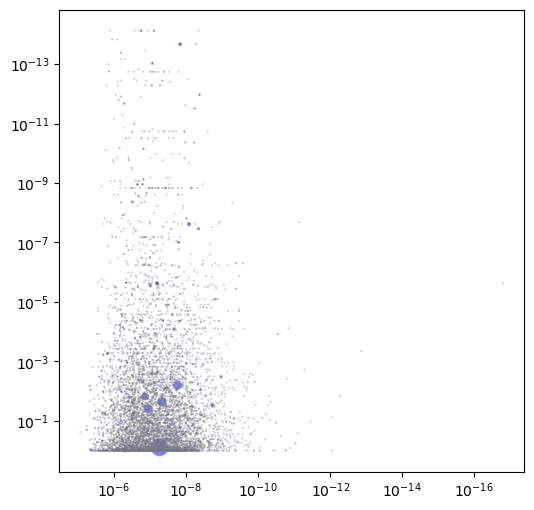

In [79]:
df_ = tr_nn.clone_df
x, y = df_['pgen_cdr3_b_aa'], df_['poisson_fdr']
s = 10000*df_['productive_frequency']

fig, ax = plt.subplots(figsize = (6, 6))
ax.scatter(x, y, s=s, alpha=0.5, facecolors='blue', edgecolors='grey')

# Set logarithmic scale on the both variables
ax.set_xscale("log")
ax.set_yscale("log");
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

#### Exclude irrelevant clones

Although this sample came from a convalescent COVID-19 patient, it is reasonable to assume that many of the clones that manifest evidence of antigenic selection may be due to exposure to common human pathogens, such as CMV, EBV, or influenza. Thus, to the extent possible, one might want to exclude clones with a higher-than-expected number of neighbors if they closely resem- ble TCRs with existing annotations to recognize these common viral epitopes. 

In [80]:
f = 'VDJdb-human-mhc1-mhc2-2021-08-20.tsv' 
if not os.path.isfile(f):
    os.system(f'wget https://github.com/kmayerb/tcrdist3_book_chapter/raw/main/data/VDJdb-human-mhc1-mhc2-2021-08-20.tsv.zip')
    os.system(f'unzip VDJdb-human-mhc1-mhc2-2021-08-20.tsv.zip')

fp_vdjdb = 'VDJdb-human-mhc1-mhc2-2021-08-20.tsv'
vdjdb = pd.read_csv(fp_vdjdb, sep = "\t")
vdjdb_to_tcrdist = {
    'CDR3':'cdr3_b_aa',
    'V':'v_b_gene', 
    'J':'j_b_gene', 
    'Score':'score', 
    'Species':'species',
    'MHC A':'mhc_a', 
    'MHC B':'mhc_b', 
    'MHC class': 'mhc_class',
    'Epitope':'epitope',
    'Epitope species':'epitope_species'}

vdjdb = vdjdb.rename(columns =vdjdb_to_tcrdist)[vdjdb_to_tcrdist.values()] 
# Here, we only use TCRs with a quality score greater than 0
vdjdb = vdjdb.query('score > 0').reset_index(drop = True)

tr_vdjdb = TCRrep(cell_df = vdjdb,
       organism = 'human',
       chains = ['beta'],
       deduplicate = False,
       compute_distances = False)

Next, we compute the distance between clones in the bulk repertoire with four or more neighbors and all of the TCRs in the VDJdb table with quality score >0.

In [81]:
tr_nn.cpus = 12
chunk_size = get_safe_chunk(tr_nn.clone_df.shape[0],
                            tr_vdjdb.clone_df.shape[0])

tr_nn.compute_sparse_rect_distances(
    df2 = tr_vdjdb.clone_df,
    radius = 72,
    chunk_size = chunk_size)

1630


In [82]:
df_join_nn =  join_by_dist(
    how = 'left',
    csrmat = tr_nn.rw_beta ,
    left_df = tr_nn.clone_df,
    right_df = tr_vdjdb.clone_df,
    left_cols  = tr_nn.clone_df.columns.to_list(),
    right_cols = tr_vdjdb.clone_df.columns.to_list(),
    left_suffix = '',
    right_suffix = '_vdjdb',
    max_n= 5,
    radius = 24)

df_join_nn['annotation'] = df_join_nn['dist'].notna()
(
    df_join_nn[[
        'k_nn',
        'k_nn_cord', 
        'poisson_fdr',
        'rank',
        'v_b_gene',
        'v_b_gene_vdjdb',
        'cdr3_b_aa',
        'cdr3_b_aa_vdjdb',
        'mhc_a_vdjdb', 
        'mhc_b_vdjdb',
        'mhc_class_vdjdb',
        'epitope_vdjdb',
        'epitope_species_vdjdb',
        'dist',
        'annotation',
        'valid_cdr3']].
      query('poisson_fdr < 0.01').
      groupby(['rank']).
      head(1)[['annotation','valid_cdr3']].
      groupby(['annotation']).
    count()
)

,valid_cdr3
annotation,
False,1932
True,47


In [83]:
df_hits = (
    df_join_nn[[
        'k_nn', 
        'k_nn_cord', 
        'poisson_fdr',
        'rank', 
        'v_b_gene',
        'v_b_gene_vdjdb',
        'cdr3_b_aa',
        'cdr3_b_aa_vdjdb',
        'mhc_a_vdjdb',
        'mhc_b_vdjdb', 
        'mhc_class_vdjdb',
        'epitope_vdjdb',
        'epitope_species_vdjdb',
        'dist',
        'annotation',
        'valid_cdr3']].
    query('poisson_fdr < 0.01')
    [[
        'annotation',
        'valid_cdr3',
        'epitope_species_vdjdb',
        'mhc_a_vdjdb', 
        'mhc_b_vdjdb', 
        'mhc_class_vdjdb']].
    groupby([
        'annotation',
        'epitope_species_vdjdb',
        'mhc_a_vdjdb',
        'mhc_b_vdjdb', 
        'mhc_class_vdjdb']).
    count()
)
df_hits

valid_cdr3
annotation epitope_species_vdjdb mhc_a_vdjdb      mhc_b_vdjdb       mhc_class_vdjdb            
True       CMV                   HLA-A*02:01      B2M               MHCI                      6
                                 HLA-B*44:03:08   B2M               MHCI                      6
           EBV                   HLA-A*02:01      B2M               MHCI                      5
                                 HLA-B*08:01      B2M               MHCI                      5
           HCV                   HLA-A*01:01      B2M               MHCI                      2
                                 HLA-A*02         B2M               MHCI                      2
                                 HLA-A*02:01      B2M               MHCI                      1
                                 HLA-B*08:01      B2M               MHCI                      1
           HIV-1                 HLA-A*02:01      B2M               MHCI                      1
                                 HLA-A*03         B2M               MHCI                      2
                                 HLA-B*07:02      B2M               MHCI                      1
                                 HLA-B*08         B2M               MHCI                      1
                                 HLA-B*27:05      B2M               MHCI                      2
                                 HLA-B*51:01      B2M               MHCI                      5
                                 HLA-B*51:193     B2M               MHCI                      1
           HomoSapiens           HLA-A*02:01      B2M               MHCI                      4
                                 HLA-DRA*01:01    HLA-DRB3*02:02    MHCII                     3
           InfluenzaA            HLA-A*02         B2M               MHCI                     28
                                 HLA-A*02:01      B2M               MHCI                     30
                                 HLA-A*02:01:48   B2M               MHCI                      3
                                 HLA-A*68:01      B2M               MHCI                      4
                                 HLA-DRA*01:02:03 HLA-DRB1*01:01:01 MHCII                     2
           M.tuberculosis        HLA-DQA1*01:02   HLA-DQB1*06:02    MHCII                     1
           YFV                   HLA-A*02         B2M               MHCI                      4

One could remove only those TCRs with an pMHC annotation matching one or more allele in the donor’s genotype or be more conservative and exclude any TCR highly similar to an already annotated TCR. Removing those TCRs with a preexisting annota- tion to a common viral epitope, we are left with approximately 2000 remaining TCRs, which, based on neighbor enrichment sta- tistics, could represent TCRs under antigenic selection following the patient’s SARS-CoV-2 infection.

In [84]:
(
    df_join_nn.query('annotation == False').
    query('poisson_fdr < 0.01').
    sort_values('poisson_fdr')
    [[
        'k_nn', 
        'k_nn_cord', 
        'poisson_fdr',
        'rank',
        'v_b_gene',
        'j_b_gene',
        'cdr3_b_aa'
    ]]
).reset_index(drop=True)

,k_nn,k_nn_cord,poisson_fdr,rank,v_b_gene,j_b_gene,cdr3_b_aa
0,17,9,0.000000,20174,TRBV12-1*01,TRBJ1-2*01,CASSPDSNYGYTF
1,14,7,0.000000,20511,TRBV12-1*01,TRBJ2-7*01,CASSLAGFSYEQYF
2,13,1,0.000000,20526,TRBV12-1*01,TRBJ2-7*01,CASSLAGVEYEQYF
3,10,1,0.000000,20578,TRBV12-1*01,TRBJ1-2*01,CASSLNRNYGYTF
4,17,2,0.000000,20067,TRBV12-1*01,TRBJ2-7*01,CASSLQNEQYF
...,...,...,...,...,...,...,...
1927,8,48,0.009805,53179,TRBV27*01,TRBJ1-1*01,CASSWGRNTEAFF
1928,8,48,0.009805,32244,TRBV7-9*01,TRBJ1-4*01,CASSLGDSNEKLFF
1929,17,143,0.009821,40538,TRBV7-8*01,TRBJ2-5*01,CASSLQETQYF
1930,7,39,0.009862,37129,TRBV19*01,TRBJ1-1*01,CASSMAGTEAFF


## MIRA-Matched Clones

This dataset is unique in that the donor also contributed samples for a multiplex identification of an antigen-specific T cell receptor assay (MIRA) experiment (experimental identifier: eLH42). This permits the opportunity to examine whether this procedure was successful at identifying SARS-CoV-2-specific TCRs that were also annotated as recognizing a SARS-CoV-2 peptide via the in vitro activation marker assays.
We load the MIRA MHC-I in vitro predictions generated from this donor and convert gene names from ImmunoSEQ to IMGT nomenclature.

In [94]:
if not os.path.isfile('eLH42_mch_i_mira_tcrs.tsv'):
    os.system('wget https://github.com/kmayerb/tcrdist3_book_chapter/raw/main/data/eLH42_mch_i_mira_tcrs.tsv')
    
df_eLH42 = pd.read_csv('eLH42_mch_i_mira_tcrs.tsv', sep = "\t")

df_eLH42['v_b_gene'] = df_eLH42['v'].apply(lambda x : adaptive_to_imgt['human'].get(x)) 
df_eLH42['j_b_gene'] = df_eLH42['j'].apply(lambda x : adaptive_to_imgt['human'].get(x))

We us an “inner” join to find clones in the bulk repertoire (among those with >4 neighbors, i.e., tr_nn.clone_df) matching the MIRA-annotated clones. An “inner” join will drop all the clones that lack a match to a MIRA clone. 

### CLONES WITH MIRA CONFIRMATION

In [90]:
# Compute number of MIRA matched clones matching a clone with > 4 within repertoire neighbors 

N_matched_clones = (
    tr_nn.clone_df.merge(
        df_eLH42, 
        how= "inner", 
        on = ['v_b_gene','j_b_gene','cdr3_b_aa']
    ).
    groupby(['v_b_gene','j_b_gene','cdr3_b_aa','rank']).
    head(1).
    shape[0]
)

In [91]:
# MIRA matched clones matching a clone with > 4 within repertoire neighbors AND FDR < 0.01

N_matched_clones_fdr_lt_01 = (
    tr_nn.clone_df.query('poisson_fdr < 0.01').
    merge(
        df_eLH42, 
        how= "inner", 
        on = ['v_b_gene', 'j_b_gene','cdr3_b_aa']
    ).
    groupby(['v_b_gene','j_b_gene','cdr3_b_aa','rank']).
    head(1).
    shape[0]
)

In [93]:
# MIRA matched clones matching a clone with > 4 within repertoire neighbors AND FDR >= 0.01

N_matched_clones_fdr_gte_01 = (
    tr_nn.clone_df.query('poisson_fdr >= 0.01').
    merge(
        df_eLH42, 
        how= "inner", 
        on = ['v_b_gene','j_b_gene','cdr3_b_aa']
    ).
    groupby(['v_b_gene','j_b_gene','cdr3_b_aa','rank']).
    head(1).
    shape[0]
)

### CLONES WITHOUT MIRA CONFIRMATION

In [96]:
# MIRA unmatched clones matching a clone with > 4 within repertoire neighbors AND FDR < 0.01 

N_unmatched_clones_fdr_lt_01 = (
    tr_nn.clone_df.query('poisson_fdr < 0.01').
    merge(
        df_eLH42, 
        how= "left", 
        on = ['v_b_gene','j_b_gene','cdr3_b_aa'], 
        indicator=True
    ).
    query("_merge == 'left_only'").
    groupby(['v_b_gene','j_b_gene','cdr3_b_aa','rank']).
    head(1).
    shape[0]
)

In [98]:
# MIRA unmatched clones matching a clone with > 4 within repertoire neighbors AND FDR >= 0.01
N_unmatched_clones_fdr_gte_01 = (
    tr_nn.clone_df.query('poisson_fdr >= 0.01').
    merge(
        df_eLH42,
        how= "left",
        on = ['v_b_gene','j_b_gene','cdr3_b_aa'], 
        indicator=True
    ).
    query("_merge == 'left_only'").
    groupby(['v_b_gene','j_b_gene','cdr3_b_aa','rank']).
    head(1).
    shape[0]
)

In [99]:
print(f"-- Considering tr_nn (k > 4) -- ")
print(f"\tnumber_of_mira_matched_clones : {N_matched_clones}") 
print(f"\tnumber_of_mira_matched_clones, fdr < 0.01 : {N_matched_clones_fdr_lt_01}") 
print(f"\tnumber_of_mira_matched_clones, fdr >= 0.01 : {N_matched_clones_fdr_gte_01}")
print(f"\tnumber_of_unmatched_clones, fdr < 0.01: {N_unmatched_clones_fdr_lt_01}") 
print(f"\tnumber_of_unmatched_clones, fdr > 0.01: {N_unmatched_clones_fdr_gte_01}")

-- Considering tr_nn (k > 4) -- 
	number_of_mira_matched_clones : 57
	number_of_mira_matched_clones, fdr < 0.01 : 38
	number_of_mira_matched_clones, fdr >= 0.01 : 19
	number_of_unmatched_clones, fdr < 0.01: 1941
	number_of_unmatched_clones, fdr > 0.01: 4410


In [100]:
table = np.array([[N_matched_clones_fdr_gte_01, N_matched_clones_fdr_lt_01],
                  [N_unmatched_clones_fdr_gte_01, N_unmatched_clones_fdr_lt_01]])

The significant result of Fisher’s exact test indicates that there is a nonrandom association between clones predicted as under anti- genic selection by the neighbor enrichment method and clones identified as antigen specific in vitro by MIRA (Table 2). However, most clones (1941 out of 1979) with a statistically significant signal of neighbor enrichment had no confirmatory MIRA result. This could be due, in part, to the lack of MIRA identification of MHC-II CD4 TCRs, which were not captured in the MIRA data considered here. Also, antigenic selection need not lead to a highly polyclonal response. Thus, MIRA may correctly identify a single expanded clone without sufficient neighbors exceeding the detection limit in this bulk repertoire.

In [101]:
#table = np.array([[19, 38], [4410, 1941]])
oddsr, p = fisher_exact(table, alternative='two-sided')
print("FDR:\n>=0.01\t<0.01")
print([N_matched_clones_fdr_gte_01, N_matched_clones_fdr_lt_01], "\tMIRA MATCHED") 
print([N_unmatched_clones_fdr_gte_01, N_unmatched_clones_fdr_lt_01] , "\tMIRA UNMATCHED") 
print(f"FISHER'S p-value: {p}")
print(f"FISHER'S p-value: {p}")

FDR:
>=0.01	<0.01
[19, 38] 	MIRA MATCHED
[4410, 1941] 	MIRA UNMATCHED
FISHER'S p-value: 4.2588712210836135e-08
FISHER'S p-value: 4.2588712210836135e-08



# Plotting code

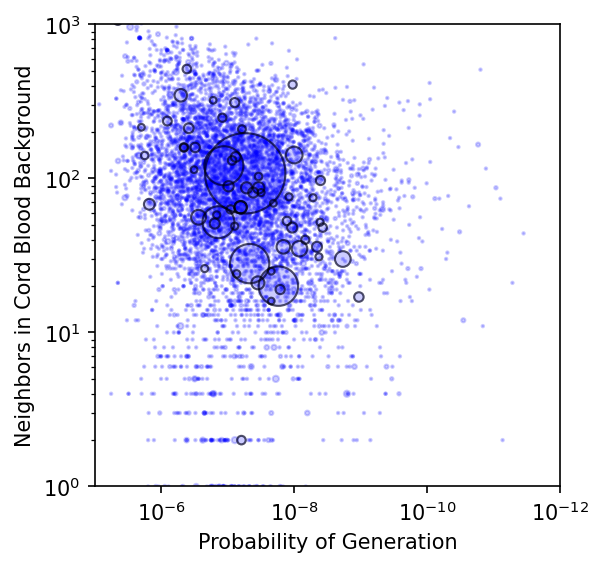

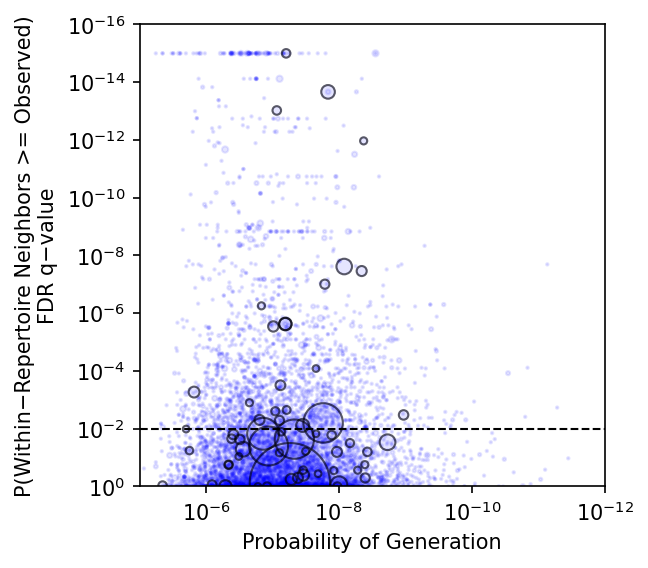

In [111]:
# Download output file with TCR-beta's: 1. Productive Frequency 2. Pgen (OLGA estimate 3. and Poisso n Probability of Within Repertoire Neighbors
file = '1588BW_20200417_PBMC_unsorted_cc1000000_ImmunRACE_050820_008_gDNA_TCRB.tsv.tcrdist3.tsv.poisson_pgen_productive_frequency.tsv'

if not os.path.exists(file):
    cmd = f'wget -O {file} shorturl.at/aju79' 
    os.system(cmd)
df = pd.read_csv(file, sep = "\t")
df['color_pf'] = df['productive_frequency'].apply(lambda x :np.log10(x))
df['poisson_fdr'] = df['poisson_fdr'].apply(lambda x: 1E-15 if x == 0 else x)

# set a shape variable proportional to productive frequency
df['s'] = df['productive_frequency'].apply(lambda x : 100000* x)

# make a second dataframe with subset of expanded clones
df2 = df.query('productive_frequency > 0.0001')

# Fig. 9A
fig = plt.figure(figsize=(4, 4), dpi=150) 
ax = fig.add_subplot()
ax.set_xscale('log') 
ax.set_yscale('log') 
ax.scatter(
    x=df['pgen_cdr3_b_aa'],
    y=df['k_nn_cord'], 
    color='blue',
    alpha = .2,
    s = df['s'] 
)

# Overplot black circles over clones with freq > 0.0001
ax.scatter(
    x=df2['pgen_cdr3_b_aa'], 
    y=df2['k_nn_cord'], 
    color='black',
    alpha = .6,
    facecolors='none', 
    s = df2['s']
)
plt.xlim((1e-5, 1e-12))
plt.ylim((1, 1e3))
plt.ylabel('Neighbors in Cord Blood Background') 
plt.xlabel('Probability of Generation')
plt.savefig("Fig9A.pdf", bbox_inches='tight')

# Fig. 9B
fig = plt.figure(figsize=(4, 4), dpi=150)
ax = fig.add_subplot()
ax.set_xscale('log') 
ax.set_yscale('log')
ax.scatter(
    x=df['pgen_cdr3_b_aa'],
    y=df['poisson_fdr'],
    color='blue',
    alpha = .1,
    s = df['s'] 
)

# Overplot black circles over clones with freq > 0.0001
ax.scatter(
    x=df2['pgen_cdr3_b_aa'], 
    y=df2['poisson_fdr'],
    color='black',
    facecolors='none',
    alpha = .6,
    s = df2['s'] 
)
ax.hlines(0.01, 1e-5, 1e-12, colors="black", linestyles='dashed', lw= 1) 
plt.xlim((1e-5, 1e-12))
plt.ylim((1, 1e-16))
plt.ylabel('P(Within−Repertoire Neighbors >= Observed)\nFDR q−value') 
plt.xlabel('Probability of Generation')
plt.savefig("Fig9B.pdf", bbox_inches='tight')